<a href="https://colab.research.google.com/github/Coding-Sorciere/PA_ICW_NWZN6/blob/main/MSIN0097_NWZN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSIN0097 Predictive Analytics Individual Coursework

## **Customer Churn Prediction for A Music Streaming Service**

Candidate ID: NWZN6


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [103]:
print("Let's help PlaylistPro!")

Let's help PlaylistPro!


# Initial Setups

## Environmental Setups

This project requires Python 3.7 or above:

In [104]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [105]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Setup tools we need later.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Business Context

PlaylistPro is a Music Streaming Service.

At PlaylistPro, one of company's top priorities is to reduce customer churn (stop customers from cancelling their subscriptions).

To reduce churn, PlaylistPro plans to reduce the cost of the music streaming service for customers that are likely to cancel their subscription. But, the company currently does not know which customers are likely or unlikely to cancel their subscription.

To help PlaylistPro, I will build a Supervised Classification Model to predict if a customer will churn based on their subscription information and listening habits, based on the 'train dataset' provided. In the end, I will apply the best performed model to the 'test dataset' provided, to make predictions on the new data.  

Training dataset and testing dataset are provided separately and can be accessed via Github. To train the model and validate, review and compare performance, I will split the 'train data' by 80:20, in which 80% of sets being used to train models and 20% used to test the performance. To avoid misunderstanding, I will refer to these 20% split of train data as 'validation data' in later codes and markdowns.

## Data Loading

In [107]:
import pandas as pd

def load_data():
    train_url = "https://raw.githubusercontent.com/Coding-Sorciere/PA_ICW_NWZN6/refs/heads/main/train.csv"
    test_url = "https://raw.githubusercontent.com/Coding-Sorciere/PA_ICW_NWZN6/refs/heads/main/test.csv"

    train_df = pd.read_csv(train_url)
    test_df = pd.read_csv(test_url)

    print("Datasets loaded successfully from GitHub!")
    return train_df, test_df

train_df, test_df = load_data()

Datasets loaded successfully from GitHub!


## Data Profiling

I check data types and non-null counts and identify categorical and numerical features.

In [108]:
train_df.head()

,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,1,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,2,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1
2,3,51,Washington,Premium,Yearly,2,Credit Card,High,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,4,63,California,Family,Yearly,4,Apple Pay,Medium,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,5,54,Washington,Family,Monthly,3,Paypal,High,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


In [109]:
print("Training Data Info:")
print(train_df.info())

# Check if there is missing values in training data
print("Missing Values in Training Data:")
print(train_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 125000 non-null  int64  
 1   age                         125000 non-null  int64  
 2   location                    125000 non-null  object 
 3   subscription_type           125000 non-null  object 
 4   payment_plan                125000 non-null  object 
 5   num_subscription_pauses     125000 non-null  int64  
 6   payment_method              125000 non-null  object 
 7   customer_service_inquiries  125000 non-null  object 
 8   signup_date                 125000 non-null  int64  
 9   weekly_hours                125000 non-null  float64
 10  average_session_length      125000 non-null  float64
 11  song_skip_rate              125000 non-null  float64
 12  weekly_songs_played         125000 non-null  int64  

# Exploratory Data Analysis (EDA)

## Feature Distribution

In [110]:
# Drop customer_id from the dataset
train_df = train_df.drop(columns=["customer_id"], errors="ignore")
test_df = test_df.drop(columns=["customer_id"], errors="ignore")

### Numerci Features

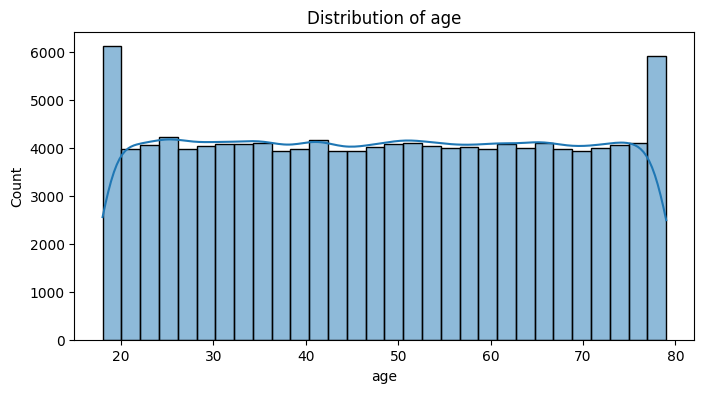

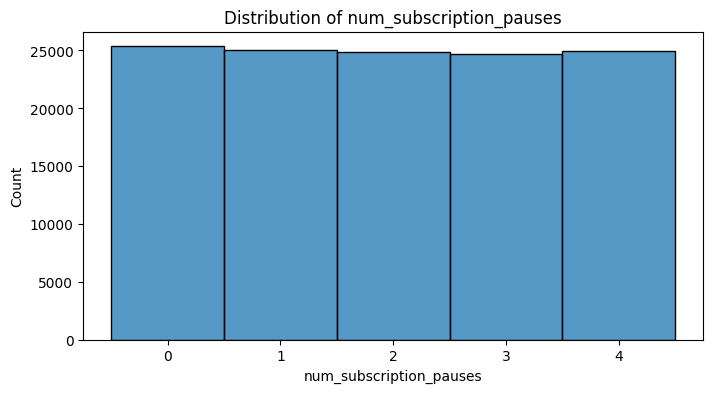

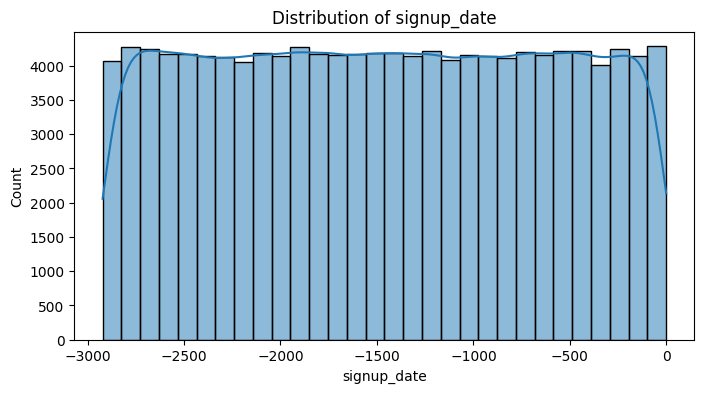

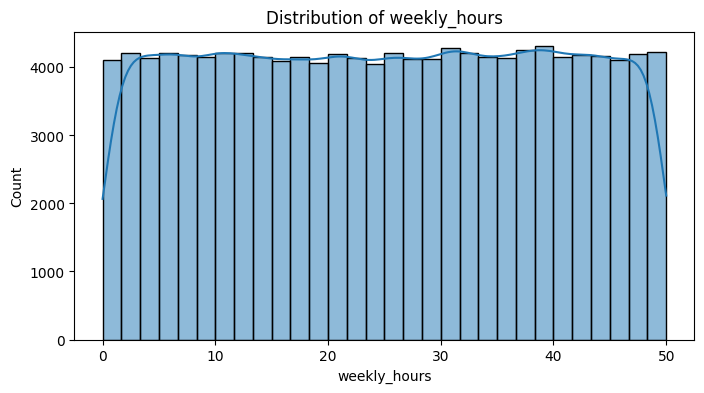

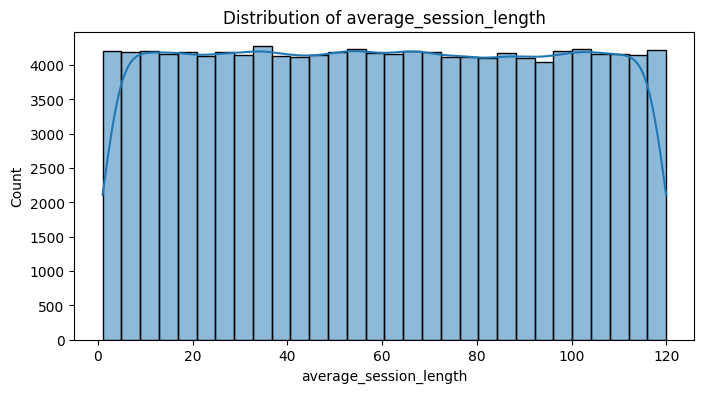

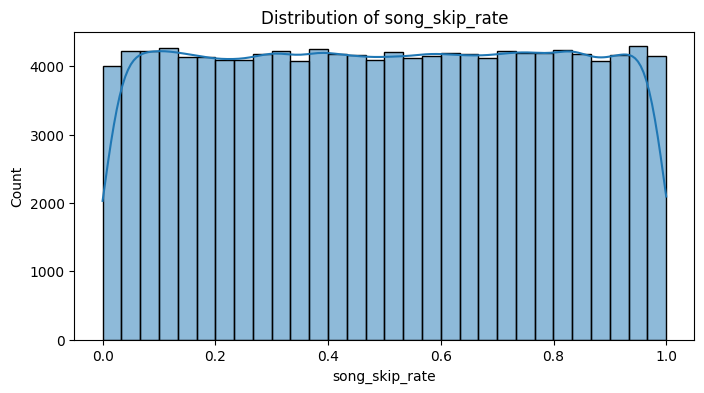

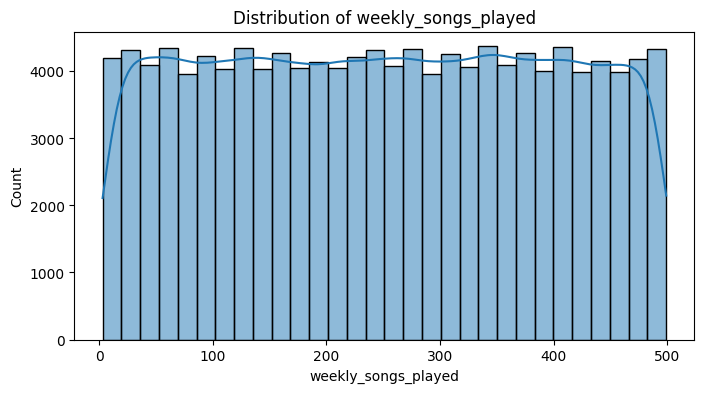

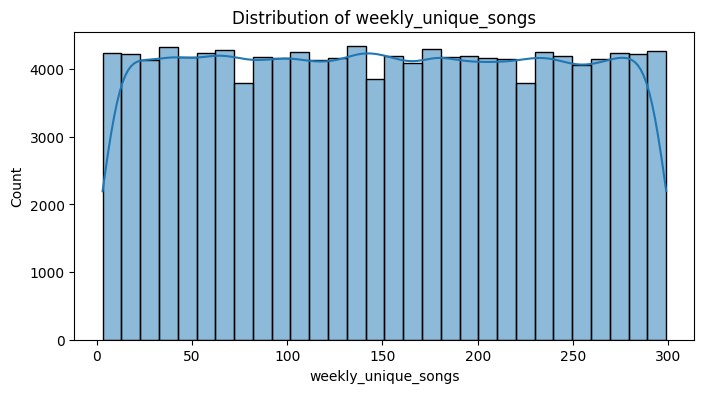

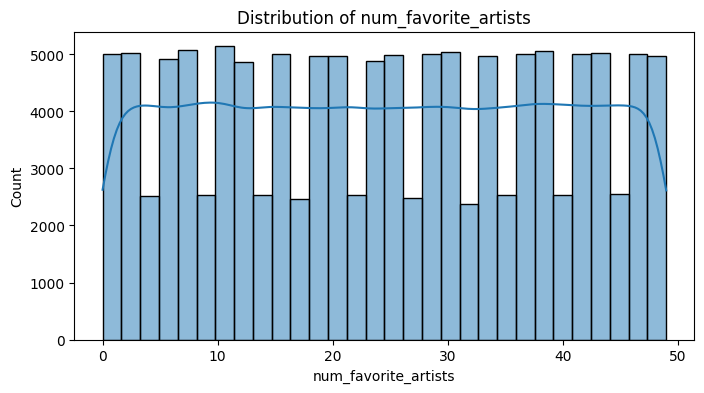

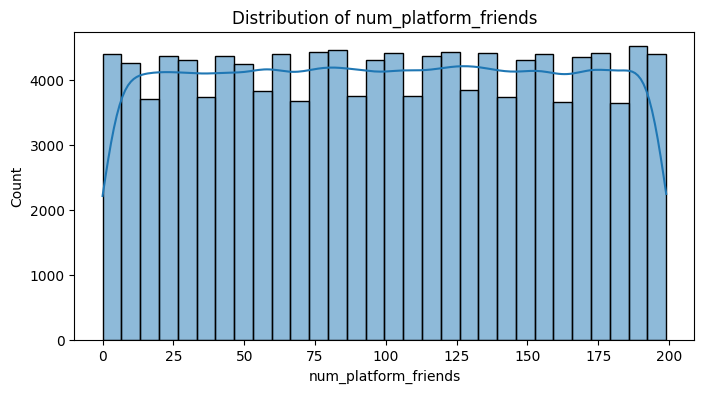

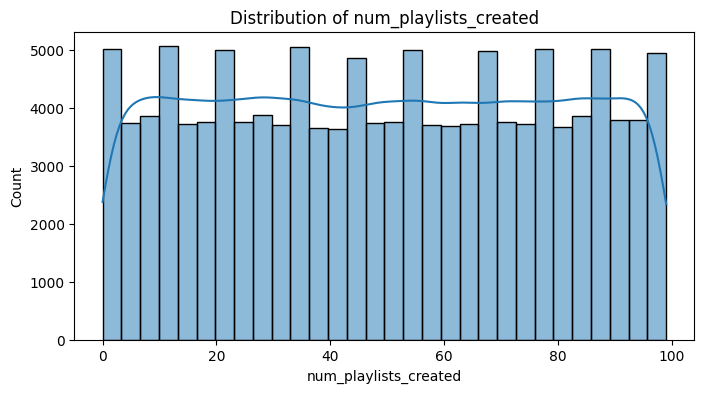

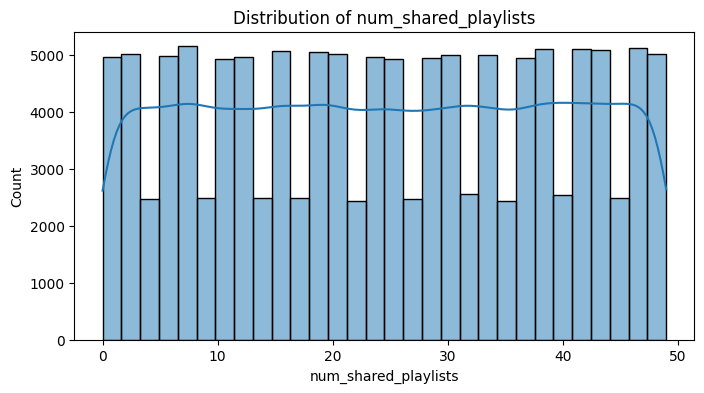

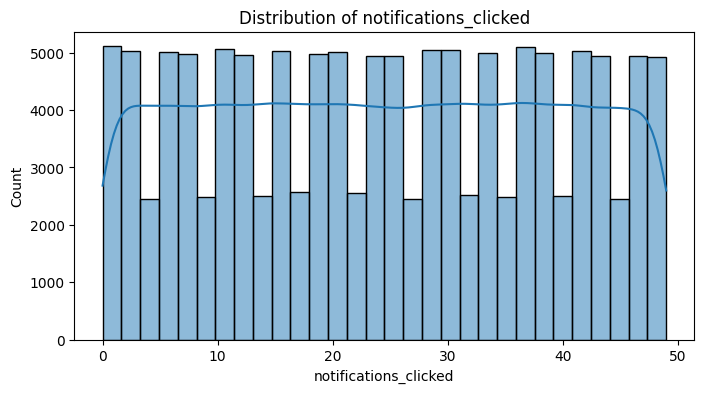

In [111]:
# Select numeric features excluding 'churned'
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('churned')

# Loop through each numerical feature and plot its distribution
for feature in numeric_features:
    plt.figure(figsize=(8, 4))  # Set figure size

    # Adjusting bins for discrete vs continuous features
    if train_df[feature].nunique() < 20:  # If the feature has fewer than 20 unique values (likely discrete)
        sns.histplot(train_df[feature], bins=train_df[feature].nunique(), discrete=True)
    else:  # For continuous features, use automatic binning
        sns.histplot(train_df[feature], bins=30, kde=True)

    plt.title(f"Distribution of {feature}")  # Dynamic title
    plt.xlabel(feature)  # Label x-axis with feature name
    plt.ylabel("Count")  # Label y-axis
    plt.show()  # Show plot before looping to the next feature

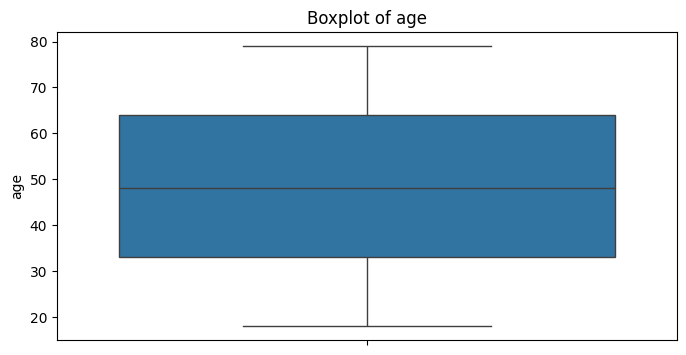

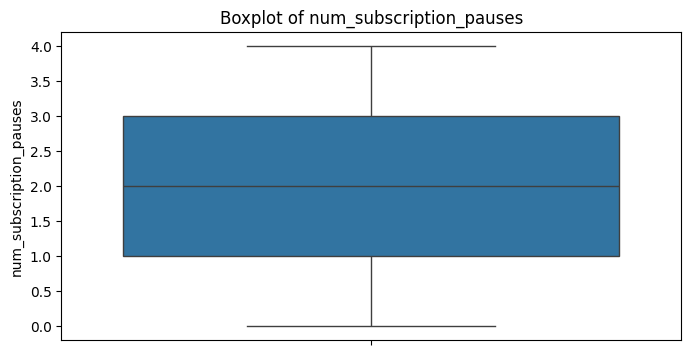

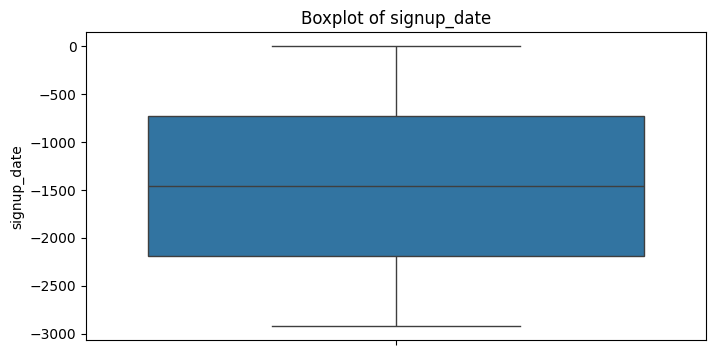

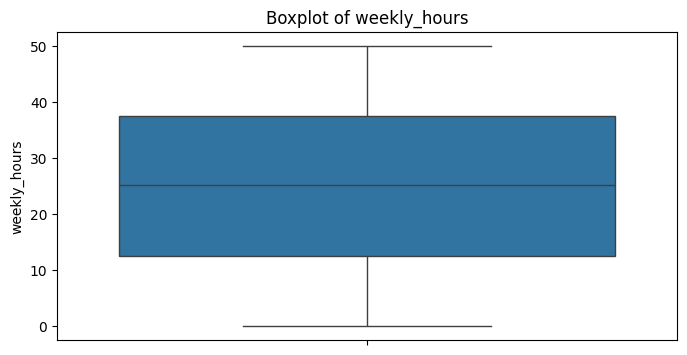

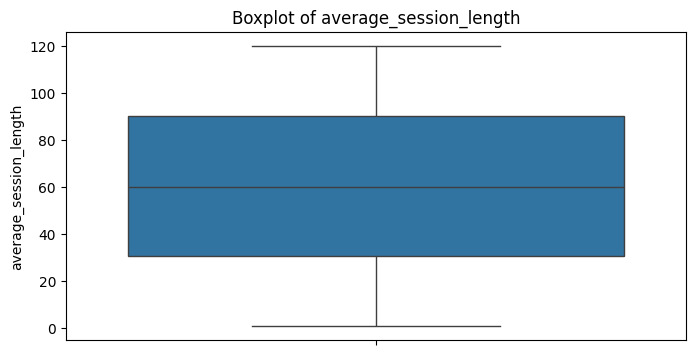

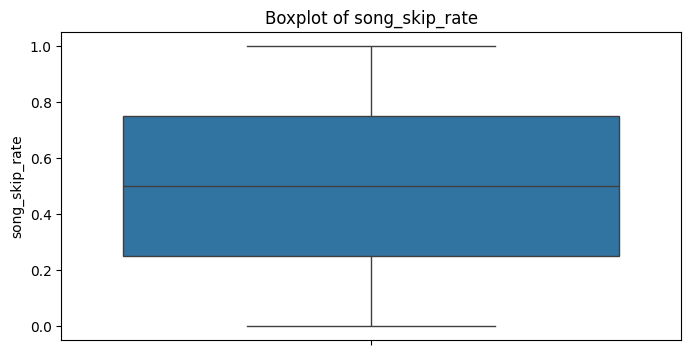

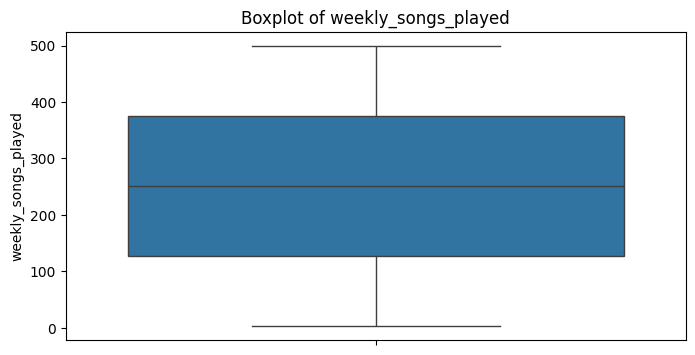

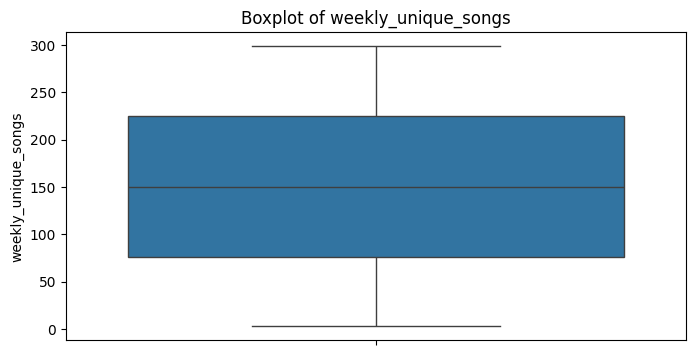

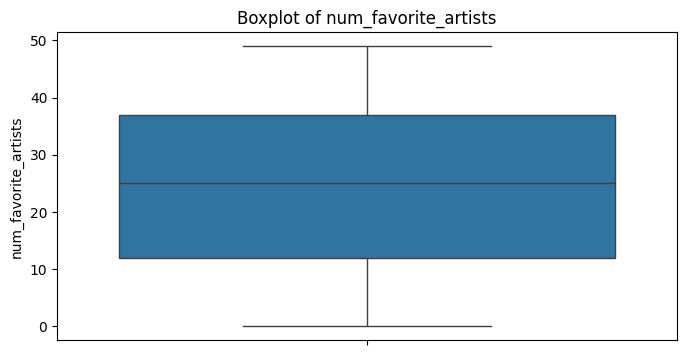

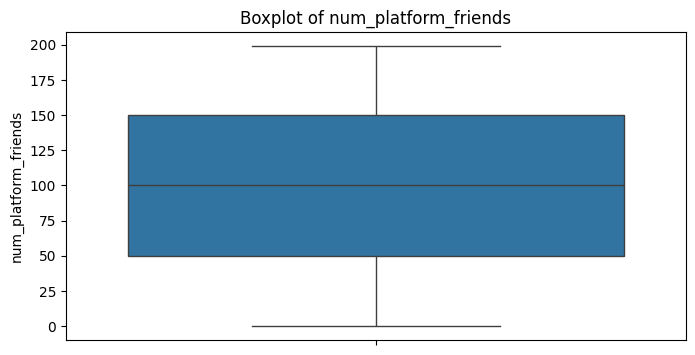

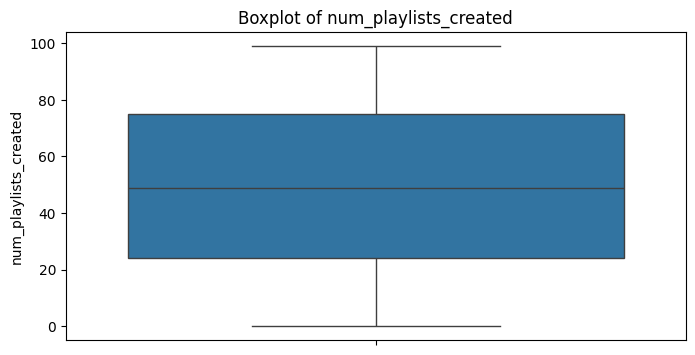

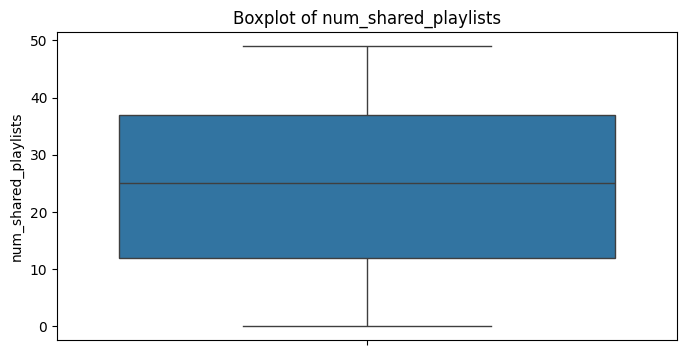

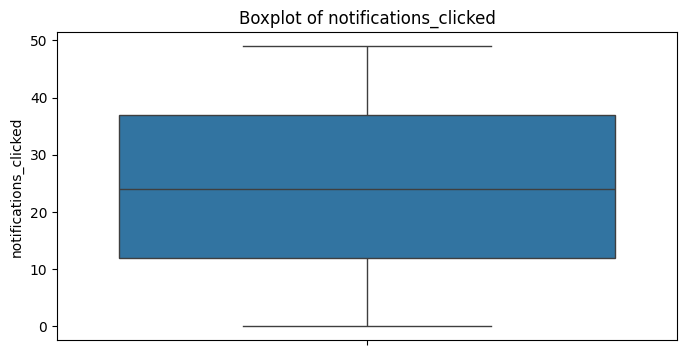

In [112]:
# Create boxplots for each numeric feature
for feature in numeric_features:
    plt.figure(figsize=(8, 4))  # Adjust figure size for clarity
    sns.boxplot(y=train_df[feature])  # Plot each feature
    plt.title(f"Boxplot of {feature}")  # Dynamic title for each feature
    plt.show()  # Display the plot before moving to the next one

### Categorical Features

1. Class Distribution of Target Feature (Churn)

To check if there is class imbalance.

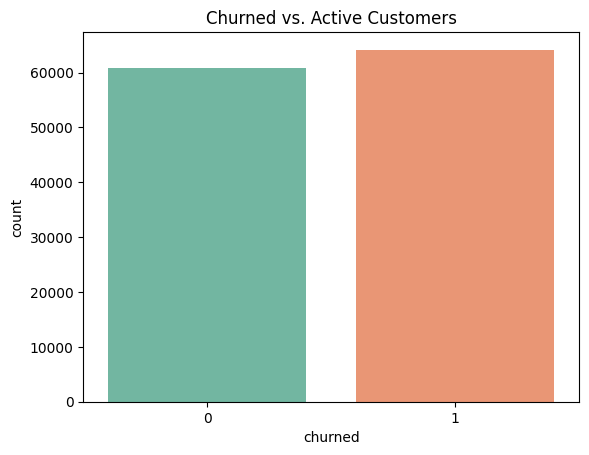

churned
1    0.513392
0    0.486608
Name: proportion, dtype: float64


In [113]:
sns.countplot(x='churned', data=train_df, hue='churned', palette='Set2', legend=False)
plt.title("Churned vs. Active Customers")
plt.show()

# Check if there is class imbalance
print(train_df['churned'].value_counts(normalize=True))

Insights: No significant class imbalance.

2. Class Distributions of Other Categorical Features



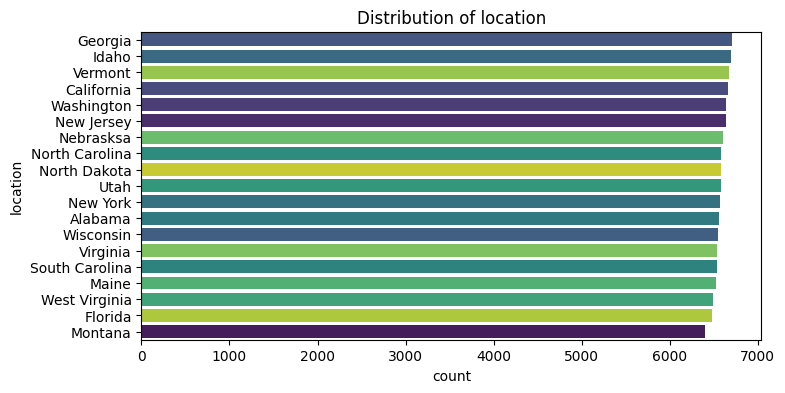

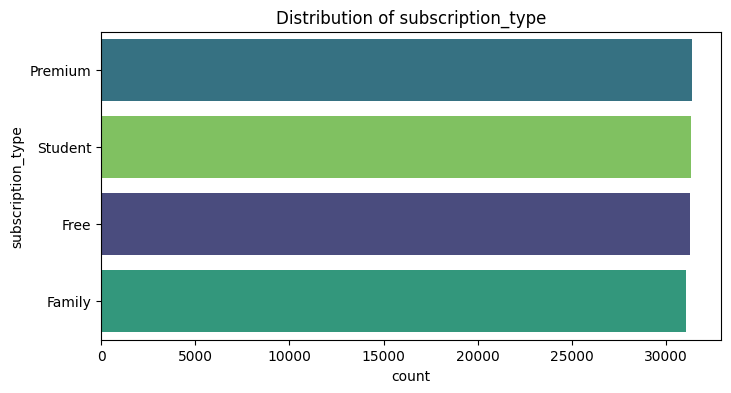

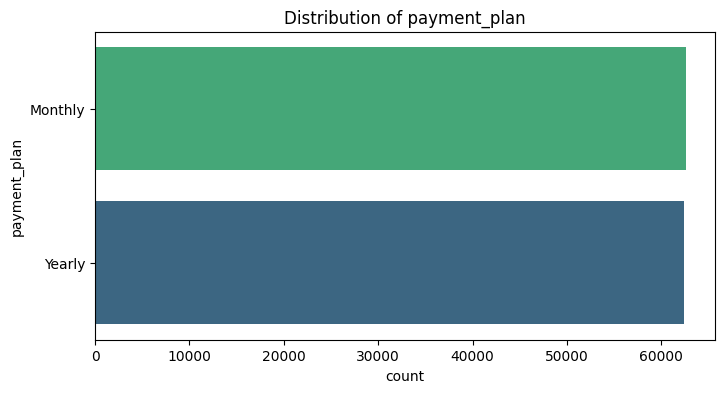

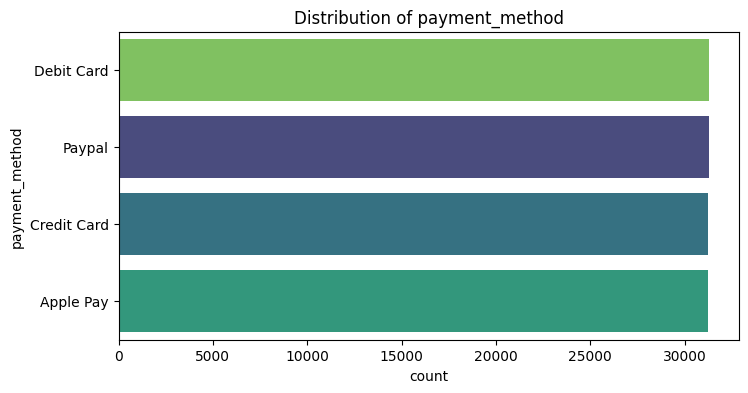

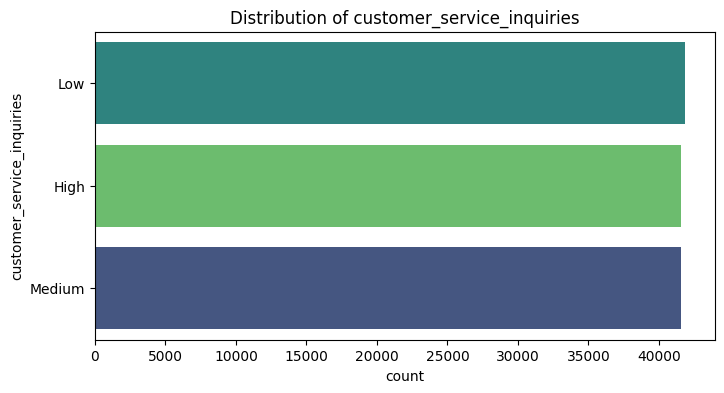

In [114]:
categorical_features = train_df.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.show()

Insights: It shows a balanced distribution in subscription_type, payment_plan, payment_method across categories and the customer_service_inquiries feature.

**Notes on Ordinal Features:**

Even though shown as nominal features (categorical features) in the datasets, 'payment_plan' and 'customer_service_inquiries' are  in fact ordinal.

Also 'age'. But age as a continuous numerical feature can be less effective in terms of model training and interpretation. So I will later define a new feature named 'age_group'.

For these ordinal features, I will process in pipeline building if they are selected.

## Correlation Matrix

For numeric features only.

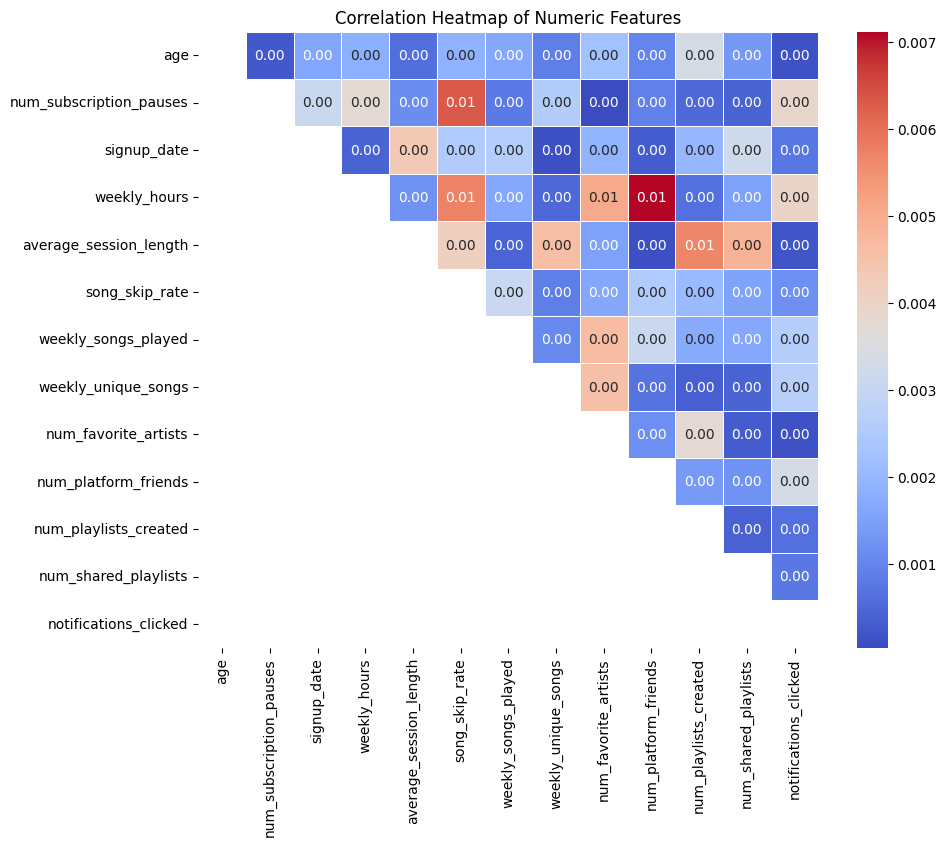

In [115]:
# Create correlation matrix
corr_matrix = train_df[numeric_features].corr().abs()

# The upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Plot the heatmap of the upper triangle
plt.figure(figsize=(10, 8))
sns.heatmap(upper_triangle, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

Insights:

The values in the heatmap mostly range between 0.00 and 0.01, meaning no meaningful linear relationship exists between most numerical features.

Features are mostly independent from each other. Since correlations are weak,no need to tackle multicollinearity.


## Mutual Information (MI)

Mutual Information (MI) analysis is a complement to correlation analysis for feature selection.

MI will demonstrate which features are most informative for predicting churn.It measures how much information one variable provides about another, even in non-linear relationships.


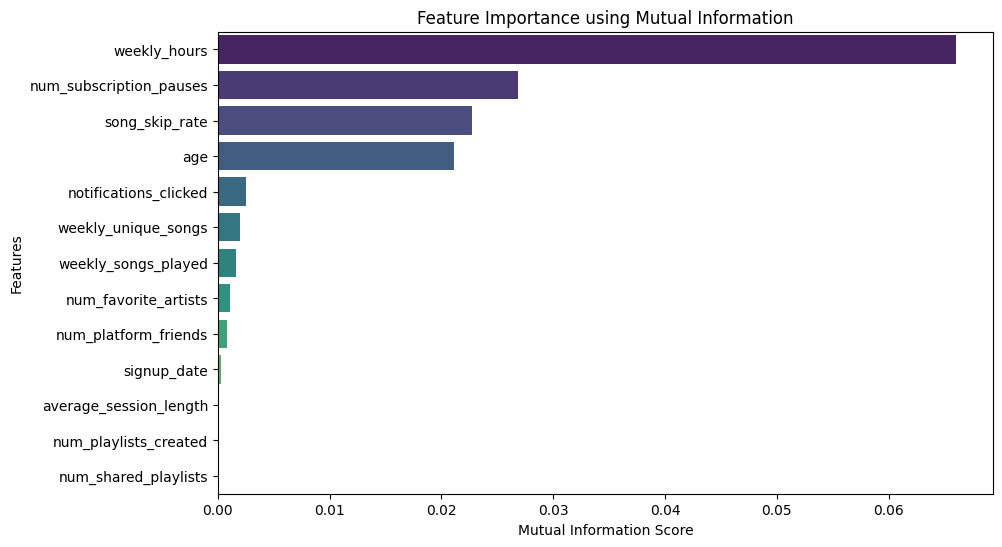

In [116]:
from sklearn.feature_selection import mutual_info_classif

# Compute MI between features and churned (target)
X = train_df.drop(columns=['churned'])
y = train_df['churned']

mi_scores = mutual_info_classif(X.select_dtypes(include=np.number), y, discrete_features=False)
mi_scores = pd.Series(mi_scores, index=X.select_dtypes(include=np.number).columns)
mi_scores.sort_values(ascending=False, inplace=True)

# Plot MI Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores, y=mi_scores.index, hue=mi_scores.index, palette="viridis", legend=False)
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information")
plt.show()

**Insights:**

1. weekly_hours is the most important feature
This suggests that how much time a user spends on the platform is highly relevant to churn.

2. Users who pause their subscriptions might be at higher risk of churning.

3. song_skip_rate and age also contribute. If users skip songs frequently, they may not be satisfied. Importance of age might suggest younger or older customers behave differently in terms of churn.

4. Several features have very low importance:
signup_date, num_favorite_artists, num_platform_friends show almost no MI score. Consider dropping these later.

# Feature Engineering

New Feature: Age Group

Age_group feature is a categorical transformation of the numerical age variable. Instead of treating age as a continuous variable, I am binning it into discrete groups, which reduces noise in models that might overfit to specific ages.

It will also makes interpretation easier by categorising users into meaningful age brackets.

In [127]:
# Define age bins and labels
bins = [0, 25, 40, 55, 65, 100]
labels = ['<25', '25-40', '41-55', '56-65', '65+']

# Apply the transformation to train and test data
train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, right=False)
test_df['age_group'] = pd.cut(test_df['age'], bins=bins, labels=labels, right=False)

In [118]:
train_df['age_group'].value_counts()

,count
age_group,
25-40,30435
41-55,30263
65+,30101
56-65,20048
<25,14153


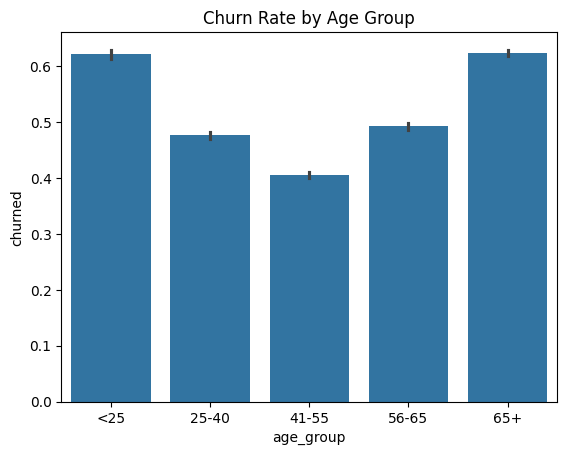

In [119]:
sns.barplot(x=train_df['age_group'], y=train_df['churned'])
plt.title("Churn Rate by Age Group")
plt.show()

# Data Splitting



In [120]:
# Define features and target
X = train_df.drop(columns=['churned'])  # Features
y = train_df['churned']  # Target variable

# Split into training and validation sets (e.g., 80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"""size of training set: {len(X_train)}
size of testing set: {len(X_val)}""")

size of training set: 100000
size of testing set: 25000


# Feature Selection

Based on previous feature engineering and EDA.

In [121]:
# choose features to use in classification model
numeric_features = ['num_subscription_pauses', 'weekly_hours', 'average_session_length', 'song_skip_rate', 'weekly_songs_played', 'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends']
nominal_features = ['location','subscription_type','payment_method']
ordinal_features = ['age_group','payment_plan','customer_service_inquiries']

all_features = numeric_features + nominal_features + ordinal_features
all_features

['num_subscription_pauses',
 'weekly_hours',
 'average_session_length',
 'song_skip_rate',
 'weekly_songs_played',
 'weekly_unique_songs',
 'num_favorite_artists',
 'num_platform_friends',
 'location',
 'subscription_type',
 'payment_method',
 'age_group',
 'payment_plan',
 'customer_service_inquiries']

# Pipelines

 I here build a pipeline to preprocess data.

 This will contribute to a better result as it ensures all preprocessing steps are applied consistently, avoids data leakage by fitting transformations only on training data, and simplifies model deployment, make it possible to be used for new data.

 Here I combine the following steps into a Pipeline:

Numerical Feature Scaling → StandardScaler

*   Log Transformations → Custom Transformer
*   One-Hot Encoding for categorical variables
*   Ordinal Encoding for customer_service_inquiries

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Define feature groups
numeric_features = ['num_subscription_pauses', 'weekly_hours', 'average_session_length', 'song_skip_rate',
                    'weekly_songs_played', 'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends']
nominal_features = ['location', 'subscription_type', 'payment_method']
ordinal_features = ['age_group', 'payment_plan', 'customer_service_inquiries']

# Define the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scaling is essential for NN
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handles NaNs before encoding
    ('ordinal', OrdinalEncoder(categories=[
        ['<25', '25-40', '41-55', '56-65', '65+'],
        ['Monthly', 'Yearly'],
        ['Low', 'Medium', 'High']
    ]))
])

# Combine transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('nominal', nominal_transformer, nominal_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ])

In [123]:
# view your pipeline
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['num_subscription_pauses', 'weekly_hours',
                                  'average_session_length', 'song_skip_rate',
                                  'weekly_songs_played', 'weekly_unique_songs',
                                  'num_favorite_artists',
                                  'num_platform_friends']),
                                ('nominal',
                                 Pipeline(steps=[('imputer',
                                                  Si...
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['location', 'subscription_type',
                                  'payment_method']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['<25',
                                                                              '25-40',
                                                                              '41-55',
                                                                              '56-65',
                                                                              '65+'],
                                                                             ['Monthly',
                                                                              'Yearly'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High']]))]),
                                 ['age_group', 'payment_plan',
                                  'customer_service_inquiries'])])

In [129]:
# Apply preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)  # Fit only on training data
X_val_transformed = preprocessor.transform(X_val)  # Transform validation data
X_test_transformed = preprocessor.transform(test_df)  # Transform test data

After applying ColumnTransformer, the transformed dataset is returned as a NumPy array, which loses feature names and makes it difficult to interpret the results.

To restore feature names and ensure consistency, I convert the transformed data back into a Pandas DataFrame using the original column names.

In [130]:
# Get feature names from ColumnTransformer
transformed_feature_names = (
    preprocessor.named_transformers_['numeric'].get_feature_names_out(numeric_features).tolist() +
    preprocessor.named_transformers_['nominal'].get_feature_names_out().tolist() +
    ordinal_features  # Ordinal features remain in the same order
)

# Convert transformed data to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=transformed_feature_names, index=X_val.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=test_df.index)

# Check if it worked
print(X_train_transformed_df.head())

       num_subscription_pauses  weekly_hours  average_session_length  \
19005                 0.006618      1.427492                1.213263   
51562                 1.417790     -0.109688               -0.203693   
86505                 0.006618      0.215180               -0.583402   
70859                -0.698967      1.705816               -0.442149   
96416                -1.404553     -0.538014               -0.933319   

       song_skip_rate  weekly_songs_played  weekly_unique_songs  \
19005       -0.273803            -0.396813             1.377621   
51562        1.099513             1.526998             0.106827   
86505        1.663907             0.739351            -0.837525   
70859       -1.031058             0.788143            -0.207957   
96416        1.430626            -0.536220            -1.198943   

       num_favorite_artists  num_platform_friends  location_Alabama  \
19005             -1.556687              0.837686               0.0   
51562             -1.0

# Benchmarking

Ensure feature dimensions are consistent across train, validation, and test sets.

In [132]:
print(X_train_transformed_df.shape, X_val_transformed_df.shape, X_test_transformed_df.shape)

(100000, 38) (25000, 38) (75000, 38)


## Train Baseline Models

To establish performance benchmarks for later neural network modeling, here I train 4 baseline models (Logistic Regression, Random Forest, Decision Tree, Gradient Boosting) and review their performances.

In [133]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Define cross-validation function
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Ensures balanced class distribution
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  # Evaluate accuracy
    return scores.mean(), scores.std()

# Define baseline models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Store results
model_results = []

for model_name, model in models.items():
    # Train model
    model.fit(X_train_transformed_df, y_train)
    y_pred = model.predict(X_val_transformed_df)

    # Perform cross-validation on training data
    cv_mean, cv_std = evaluate_model(model, X_train_transformed_df, y_train)

    # Calculate performance metrics
    results = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred),
        "AUC-ROC": roc_auc_score(y_val, y_pred),
        "CV Accuracy Mean": cv_mean,
        "CV Accuracy Std": cv_std
    }

    model_results.append(results)

# Display results in a DataFrame
results_df = pd.DataFrame(model_results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.80528   0.815425  0.802337  0.808828  0.805361   
1        Random Forest   0.84324   0.843029  0.853603  0.848283  0.842955   
2        Decision Tree   0.79140   0.797285  0.796104  0.796694  0.791270   
3    Gradient Boosting   0.84404   0.835687  0.866615  0.850870  0.843418   

   CV Accuracy Mean  CV Accuracy Std  
0           0.80060         0.002439  
1           0.83992         0.002581  
2           0.78440         0.002015  
3           0.84219         0.003147  


Comments on Baseline Models Performance

1. Gradient Boosting (MVP)

Highest Accuracy (0.84404), Best Recall (0.8666), and Best F1-score (0.8509).

Boosting algorithms tend to work well on structured data, correcting mistakes iteratively.

2. Random Forest Second Best

High Accuracy (0.84324) and Strong Precision (0.8430).

Works well without needing much hyperparameter tuning.

Slightly worse Recall than Gradient Boosting, meaning it may miss some positive cases.

3. Logistic Regression

Accuracy (0.80528) is lower than tree-based models.

Precision is high (0.8154), meaning fewer false positives.

Useful for interpretability but may not be the best model for this dataset.

4. Decision Tree

Lowest Accuracy (0.79140) and highest overfitting risk.

Decision Trees are prone to overfitting, unlike ensemble methods like Random Forest.


Therefore, I shortlist 2 best models so far:


*   Gradient Boosting (Best Recall, F1-Score, and CV Accuracy)
*   Random Forest (Consistently strong performance)


## Fine-Tune Shortlisted Baseline Models

To establish stronger benchmarks for advanced models, I shortlisted and finetuned two baseline models, i.e. Random Forest and Gradient Boosting classifier.

I choose the Randomized Search method to apply on the two models. It performs a randomised hyperparameter search with 10 iterations and 3-fold cross-validation to optimize performance without excessive computation.

My dataset contains 125,000 customer records (10000 training, 2500 validation), making a broad hyperparameter space exhausively time-consuming and resource-intensive. Thus Grid Search in our case is less favoured.

### Fine-tune Random Forest Classifier

In [135]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of each tree (limits tree complexity)
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features considered for splitting
    'bootstrap': [True, False]  # Whether to use bootstrapping (sampling with replacement)
}

# Initialize the base Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,  # The base model to tune
    param_distributions=param_grid,  # The hyperparameter space
    n_iter=10,  # Number of random combinations to try (limits search time)
    scoring='accuracy',  # Metric to optimize (can change to 'roc_auc' if needed)
    cv=3,  # Number of cross-validation folds (reduced from 5 to save computation)
    verbose=2,  # Prints progress updates during search
    random_state=42,  # Ensures reproducibility
    n_jobs=-1  # Utilizes all available CPU cores for parallel processing
)

# Perform the hyperparameter search using the training data
random_search.fit(X_train_transformed_df, y_train)

# Display the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print(f"Best Cross-Validated Accuracy: {random_search.best_score_:.4f}")

# Retrieve the best model with optimized hyperparameters
best_rf_model = random_search.best_estimator_

# Train the best Random Forest model on the full training data
best_rf_model.fit(X_train_transformed_df, y_train)

# Make predictions on the validation set
y_pred = best_rf_model.predict(X_val_transformed_df)

# Compute performance metrics for evaluation
rf_results = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1-score": f1_score(y_val, y_pred),
    "AUC-ROC": roc_auc_score(y_val, y_pred)
}

# Display the model evaluation results in a DataFrame
print(pd.DataFrame([rf_results]))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best Cross-Validated Accuracy: 0.8402
   Accuracy  Precision    Recall  F1-score   AUC-ROC
0    0.8452   0.840952  0.861395  0.851051  0.844754


### Fine-tune Gradient Boosting Classifier

In [136]:
# Define the hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Controls step size at each boosting step
    'max_depth': [3, 5, 7],  # Maximum depth of each tree (limits complexity)
    'min_samples_split': [2, 5],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'subsample': [0.7, 0.9, 1.0]  # Fraction of samples used for fitting each tree (reduces overfitting)
}

# Initialize the base Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=gb_model,  # The base model to tune
    param_distributions=param_grid,  # The hyperparameter space
    n_iter=10,  # Number of random combinations to try (reduced for efficiency)
    scoring='accuracy',  # Metric to optimize (can change to 'roc_auc' for AUC-ROC optimization)
    cv=3,  # 3-fold cross-validation for efficiency
    verbose=2,  # Prints progress updates during search
    random_state=42,  # Ensures reproducibility
    n_jobs=-1  # Utilizes all available CPU cores for parallel processing
)

# Perform the hyperparameter search using the training data
random_search.fit(X_train_transformed_df, y_train)

# Display the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print(f"Best Cross-Validated Accuracy: {random_search.best_score_:.4f}")

# Retrieve the best model with optimized hyperparameters
best_gb_model = random_search.best_estimator_

# Train the best Gradient Boosting model on the full training data
best_gb_model.fit(X_train_transformed_df, y_train)

# Make predictions on the validation set
y_pred = best_gb_model.predict(X_val_transformed_df)

# Compute performance metrics for evaluation
gb_results = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1-score": f1_score(y_val, y_pred),
    "AUC-ROC": roc_auc_score(y_val, y_pred)
}

# Display the model evaluation results in a DataFrame
print(pd.DataFrame([gb_results]))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}
Best Cross-Validated Accuracy: 0.8440
   Accuracy  Precision    Recall  F1-score   AUC-ROC
0    0.8458   0.831904  0.876821  0.853772  0.844946


## Benchmark Conclusion

The fine-tuned Gradient Boosting Classifier performs the best among all baseline models and their fine-tunes, thus is chosen as the benchmark.

**Benchmark:**

Best Model: Fine-tuned Gradient Boosting Classifier

Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}

Best Metrics:

*   Cross-Validated Accuracy: 0.8440
*   Accuracy: 0.8458
*   Precision: 0.831904
*   Recall: 0.876821
*   F1-score: 0.853772
*   AUC-ROC: 0.844946

# Neural Network Model Training

## Train Neural Network Model: MLP

In [137]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the MLP model function
def create_mlp_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Explicitly define input layer with correct dimensions
        Dense(128, activation='relu'),  # Increased neurons for better feature learning
        Dropout(0.3),  # Dropout to reduce overfitting
        Dense(64, activation='relu'),
        Dropout(0.2),  # Additional regularization
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model

# Get input dimensions from transformed training data
input_dim = X_train_transformed_df.shape[1]
mlp_model = create_mlp_model(input_dim)

# Display model summary
mlp_model.summary()

# Compile the model with additional evaluation metric (AUC-ROC)
mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="AUC-ROC")]
)

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if val_loss does not improve for 5 consecutive epochs
    restore_best_weights=True  # Restore best model weights
)

# Train the model using transformed data
history = mlp_model.fit(
    X_train_transformed_df, y_train,  # Use transformed training data
    epochs=50,  # Number of passes through training data
    batch_size=32,  # Mini-batch size for gradient updates
    validation_data=(X_val_transformed_df, y_val),  # Use validation data for monitoring
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_accuracy, val_auc_roc = mlp_model.evaluate(X_val_transformed_df, y_val)
print("\nValidation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC-ROC: 0.8620 - accuracy: 0.7774 - loss: 0.4550 - val_AUC-ROC: 0.9104 - val_accuracy: 0.8197 - val_loss: 0.3765
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - AUC-ROC: 0.9064 - accuracy: 0.8191 - loss: 0.3851 - val_AUC-ROC: 0.9177 - val_accuracy: 0.8290 - val_loss: 0.3607
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC-ROC: 0.9126 - accuracy: 0.8254 - loss: 0.3723 - val_AUC-ROC: 0.9197 - val_accuracy: 0.8310 - val_loss: 0.3569
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - AUC-ROC: 0.9150 - accuracy: 0.8278 - loss: 0.3673 - val_AUC-ROC: 0.9211 - val_accuracy: 0.8353 - val_loss: 0.3531
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - AUC-ROC: 0.9169 - accuracy: 0.8304 - loss: 0.3629 - val_AUC-ROC: 0.9218 - val_accuracy: 0.8345 - val_loss: 0.3517
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - AUC-ROC: 0.9176 - accuracy: 0.8307 - loss: 0.3612 - val_AUC-ROC: 0.9228 - val_accuracy: 

## Fine-tune MLP Model

In [138]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define ReduceLROnPlateau to adapt learning rate when performance plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

# Recompile the existing model with an adaptive learning rate
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Maintain a small learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="AUC-ROC")]
)

# Fine-tune the existing model
history_finetune = mlp_model.fit(
    X_train_transformed_df, y_train,
    epochs=50,  # Additional fine-tuning epochs
    batch_size=32,
    validation_data=(X_val_transformed_df, y_val),
    callbacks=[reduce_lr],
    verbose=1
)

# Evaluate the fine-tuned model on validation data
val_loss, val_accuracy, val_auc_roc = mlp_model.evaluate(X_val_transformed_df, y_val)
print("\nFine-Tuned Neural Network Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - AUC-ROC: 0.9310 - accuracy: 0.8462 - loss: 0.3316 - val_AUC-ROC: 0.9280 - val_accuracy: 0.8392 - val_loss: 0.3374 - learning_rate: 0.0010
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - AUC-ROC: 0.9309 - accuracy: 0.8460 - loss: 0.3317 - val_AUC-ROC: 0.9276 - val_accuracy: 0.8403 - val_loss: 0.3384 - learning_rate: 0.0010
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - AUC-ROC: 0.9310 - accuracy: 0.8441 - loss: 0.3312 - val_AUC-ROC: 0.9276 - val_accuracy: 0.8382 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 4/50
3121/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC-ROC: 0.9315 - accuracy: 0.8454 - loss: 0.3300
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC-ROC: 0.9315 - accuracy: 0.8454 - loss: 0.3300 - val_AUC-ROC: 0.9278 - val_accuracy: 0.8394 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms

# Comparison and Decision in Model Selection

## Error Analysis

For a more informative decision-making in model selection.

Even though NN performed better,

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


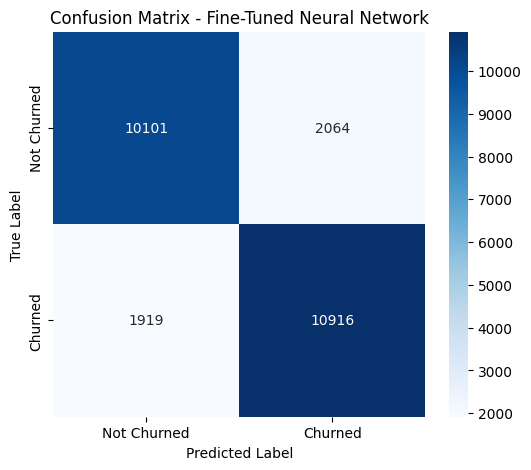


Classification Report - Fine-Tuned Neural Network:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     12165
           1       0.84      0.85      0.85     12835

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


Fine-Tuned Neural Network - Misclassification Analysis:
Total Misclassified Samples: 3983 out of 25000
False Positive Rate (Non-churners predicted as churners): 16.97%
False Negative Rate (Missed churners): 14.95%


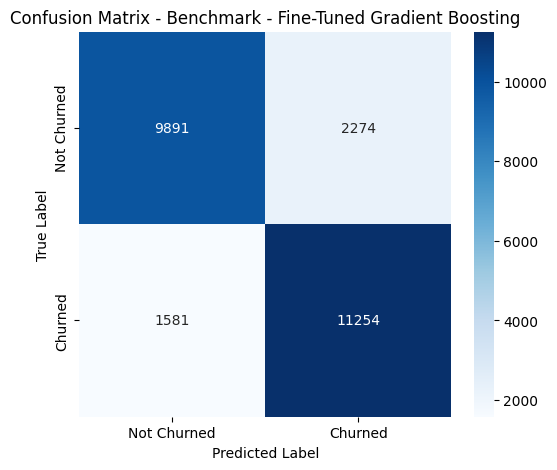


Classification Report - Benchmark - Fine-Tuned Gradient Boosting:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84     12165
           1       0.83      0.88      0.85     12835

    accuracy                           0.85     25000
   macro avg       0.85      0.84      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Benchmark - Fine-Tuned Gradient Boosting - Misclassification Analysis:
Total Misclassified Samples: 3855 out of 25000
False Positive Rate (Non-churners predicted as churners): 18.69%
False Negative Rate (Missed churners): 12.32%


In [139]:
from sklearn.metrics import confusion_matrix, classification_report

# Function to analyze errors for each model
def analyze_errors(model, X_val, y_val, model_name):
    """Generates confusion matrix and misclassification statistics for a given model."""

    # Get predictions (special handling for Neural Network)
    if model_name == "Fine-Tuned Neural Network":
        y_pred_prob = model.predict(X_val)  # Get probability scores
        y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert to binary predictions
    else:
        y_pred = model.predict(X_val)  # Direct predictions for ML models

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Print classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_val, y_pred))

    # Compute error breakdown
    fp = conf_matrix[0, 1]  # False Positives (Predicted Churn, Actually Not Churned)
    fn = conf_matrix[1, 0]  # False Negatives (Predicted Not Churned, Actually Churned)
    tp = conf_matrix[1, 1]  # True Positives
    tn = conf_matrix[0, 0]  # True Negatives
    total_errors = fp + fn
    total_samples = np.sum(conf_matrix)

    # Print error breakdown
    print(f"\n{model_name} - Misclassification Analysis:")
    print(f"Total Misclassified Samples: {total_errors} out of {total_samples}")
    print(f"False Positive Rate (Non-churners predicted as churners): {fp / (fp + tn):.2%}")
    print(f"False Negative Rate (Missed churners): {fn / (fn + tp):.2%}")

# Run error analysis for only Fine-Tuned NN and Fine-Tuned Gradient Boosting
analyze_errors(mlp_model, X_val_transformed_df, y_val, "Fine-Tuned Neural Network")
analyze_errors(best_gb_model, X_val_transformed_df, y_val, "Benchmark - Fine-Tuned Gradient Boosting")

## Exploring Ensembling Gradient Boosting and MLP

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ensemble Model Performance:
   Accuracy  Precision    Recall  F1-score   AUC-ROC
0   0.84408   0.836509  0.865446  0.850731  0.843492


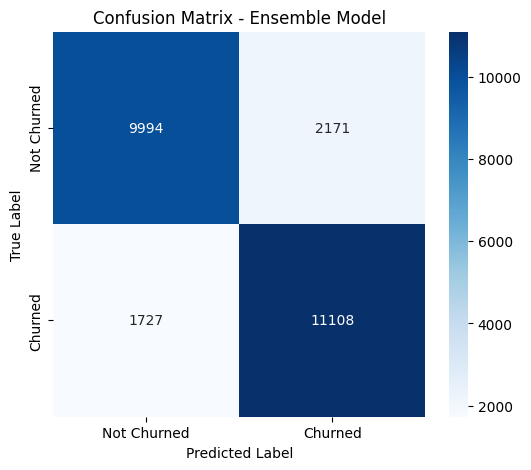


Classification Report - Ensemble Model:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     12165
           1       0.84      0.87      0.85     12835

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [141]:
# Get probability predictions from both models
y_pred_prob_nn = mlp_model.predict(X_val_transformed_df)  # NN outputs probabilities
y_pred_prob_gb = best_gb_model.predict_proba(X_val_transformed_df)[:, 1]  # Get probability of churn from GB

# Compute average probability
y_pred_ensemble_prob = (y_pred_prob_nn.flatten() + y_pred_prob_gb) / 2

# Convert to final binary predictions using a 0.5 threshold
y_pred_ensemble = (y_pred_ensemble_prob >= 0.5).astype(int)

# Compute evaluation metrics
ensemble_results = {
    "Accuracy": accuracy_score(y_val, y_pred_ensemble),
    "Precision": precision_score(y_val, y_pred_ensemble),
    "Recall": recall_score(y_val, y_pred_ensemble),
    "F1-score": f1_score(y_val, y_pred_ensemble),
    "AUC-ROC": roc_auc_score(y_val, y_pred_ensemble)
}

# Print performance metrics
import pandas as pd
print("Ensemble Model Performance:")
print(pd.DataFrame([ensemble_results]))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_ensemble)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

# Print classification report
print("\nClassification Report - Ensemble Model:")
print(classification_report(y_val, y_pred_ensemble))

## Visualise Model Selection

I compare the three models (Fine-tuned GB, Fine-tuned NN and their ensemble), based on the following metrics:


*  Model Performance (Accuracy, Precision, Recall, F1-score, AUC-ROC)
*  Confusion Matrix
*  Precision-Recall Trade-Off

Model Performance Metrics Comparison:
                       Model  Accuracy  Precision  Recall  F1-score  AUC-ROC
   Fine-Tuned Neural Network    0.8407     0.8400  0.8500    0.8500   0.9282
Fine-Tuned Gradient Boosting    0.8458     0.8300  0.8800    0.8500   0.8449
          Ensemble (NN + GB)    0.8441     0.8365  0.8654    0.8507   0.8435
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


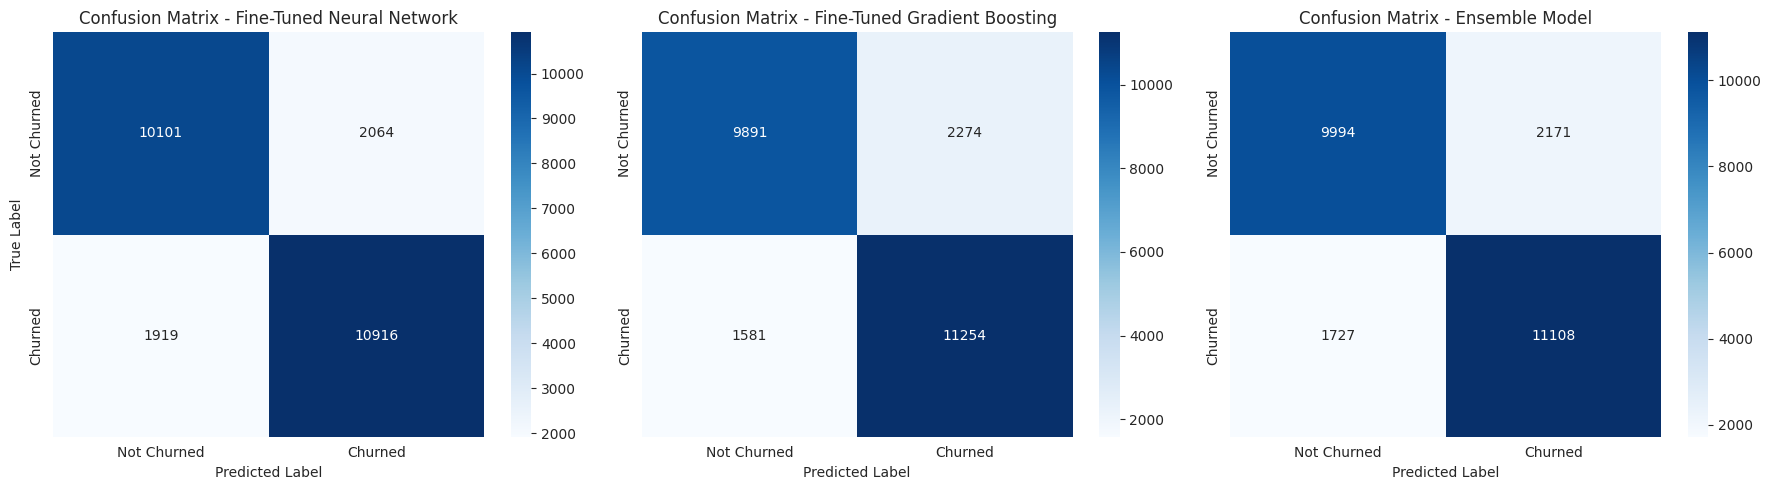

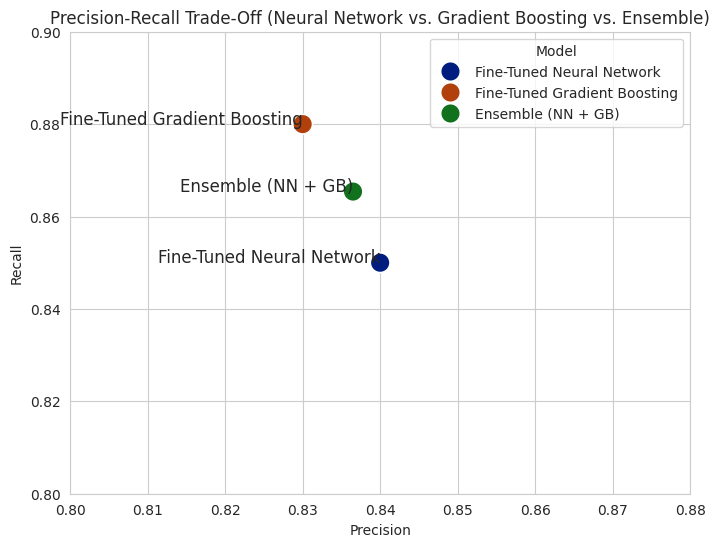

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set seaborn style for visualization
sns.set_style("whitegrid")

# Model performance metrics stored in a DataFrame
model_results = pd.DataFrame({
    "Model": ["Fine-Tuned Neural Network", "Fine-Tuned Gradient Boosting", "Ensemble (NN + GB)"],
    "Accuracy": [0.8407, 0.8458, 0.8441],
    "Precision": [0.84, 0.83, 0.8365],
    "Recall": [0.85, 0.88, 0.8654],
    "F1-score": [0.85, 0.85, 0.8507],
    "AUC-ROC": [0.9282, 0.8449, 0.8435]
})

# Display model performance metrics as a table
print("Model Performance Metrics Comparison:")
print(model_results.to_string(index=False))


# Function to plot side-by-side confusion matrices
def plot_confusion_matrices(y_true, y_pred_nn, y_pred_gb, y_pred_ensemble, labels=["Not Churned", "Churned"]):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Neural Network Confusion Matrix
    cm_nn = confusion_matrix(y_true, y_pred_nn)
    sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Confusion Matrix - Fine-Tuned Neural Network")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Gradient Boosting Confusion Matrix
    cm_gb = confusion_matrix(y_true, y_pred_gb)
    sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Confusion Matrix - Fine-Tuned Gradient Boosting")
    axes[1].set_xlabel("Predicted Label")

    # Ensemble Confusion Matrix
    cm_ensemble = confusion_matrix(y_true, y_pred_ensemble)
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title("Confusion Matrix - Ensemble Model")
    axes[2].set_xlabel("Predicted Label")

    plt.tight_layout()
    plt.show()


# Get model predictions
y_pred_nn = (mlp_model.predict(X_val_transformed_df) >= 0.5).astype(int)
y_pred_gb = best_gb_model.predict(X_val_transformed_df)
y_pred_prob_ensemble = (mlp_model.predict(X_val_transformed_df).flatten() + best_gb_model.predict_proba(X_val_transformed_df)[:, 1]) / 2
y_pred_ensemble = (y_pred_prob_ensemble >= 0.5).astype(int)

# Plot confusion matrices for all models
plot_confusion_matrices(y_val, y_pred_nn, y_pred_gb, y_pred_ensemble)


# Prepare data for precision-recall trade-off plot
precision_recall = pd.DataFrame({
    "Model": ["Fine-Tuned Neural Network", "Fine-Tuned Gradient Boosting", "Ensemble (NN + GB)"],
    "Precision": [0.84, 0.83, 0.8365],
    "Recall": [0.85, 0.88, 0.8654]
})

# Scatter plot for precision vs. recall
plt.figure(figsize=(8, 6))
sns.scatterplot(data=precision_recall, x="Precision", y="Recall", hue="Model", s=200, palette="dark")

# Annotate points
for i, row in precision_recall.iterrows():
    plt.text(row["Precision"], row["Recall"], row["Model"], fontsize=12, ha='right')

plt.title("Precision-Recall Trade-Off (Neural Network vs. Gradient Boosting vs. Ensemble)")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.xlim(0.80, 0.88)
plt.ylim(0.80, 0.90)
plt.grid(True)
plt.show()

**Analysis:**

1. Takeaways from comparison above.

Neural Network (NN) has the best AUC-ROC (0.9282), indicating it is the strongest at distinguishing between churners and non-churners.

Gradient Boosting (GB) has the highest recall (0.88), meaning it is the best at identifying churners but at the cost of more false positives.

The Ensemble (NN + GB) slightly balances precision and recall but does not significantly improve over the individual models.

2. Confusion Matrix Analysis

NN has fewer false positives than GB, meaning it makes fewer unnecessary churn predictions.

GB has fewer false negatives than NN, meaning it catches more actual churners.

Ensemble does not significantly reduce errors compared to individual models.

3. Precision-Recall Trade-Off

NN has better precision (0.84) than GB (0.83), meaning it is more confident in churn predictions.

GB has better recall (0.88), meaning it is more aggressive in detecting churners.

The ensemble is a middle ground but does not significantly outperform NN or GB individually.




## Decision: Fine-tuned Neural Network



Best AUC-ROC (0.9282), meaning the best ranking model for churn risk.

Higher precision (0.84) than GB, leading to fewer unnecessary retention actions.

Balanced recall (0.85), making it effective without excessive false positives.

The ensemble does not provide a significant advantage over NN.

# Test Data Prediction

Since we have selected the Fine-Tuned Neural Network as the best model, we will:

Apply the trained NN to the test dataset.

Generate churn probabilities and final predictions.

Store the predictions in a DataFrame and save them to a CSV file.

In [151]:
# Generate churn probability predictions from Fine-Tuned Neural Network
nn_test_prob = mlp_model.predict(X_test_transformed_df).flatten()  # Probability of churn

# Convert probabilities to binary class predictions using a threshold of 0.5
nn_test_pred = (nn_test_prob >= 0.5).astype(int)

# Create a DataFrame to store test predictions
test_predictions = pd.DataFrame({
    'id': test_df.index,  # Assuming test_df has an index or unique identifier
    'churn_prediction': nn_test_pred,
    'churn_probability': nn_test_prob
})

print("Test predictions generated. Sample output:")
print(test_predictions.head())

# Save predictions to a CSV file for submission or further analysis
test_predictions.to_csv("test_predictions.csv", index=False)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test predictions generated. Sample output:
   id  churn_prediction  churn_probability
0   0                 1           0.861142
1   1                 0           0.272968
2   2                 1           0.739859
3   3                 1           0.513117
4   4                 0           0.466325
